<a href="https://colab.research.google.com/github/Phionanamugga/NLP_projects/blob/feature1/FoodReviewsTTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End NLP Pipeline for Customer Sentiment Analysis of Amazon Food

## Problem Statement

Business Problem: Amazon seeks to enhance customer satisfaction by analyzing sentiment in the food sold on its website. Understanding whether reviews are  negative,positive, or neutral can guide marketing strategies,product improvements,  and customer service satisfaction.

Importance: Positive sentiment drives customer loyalty, while negative sentiment can harm brand reputation. An automated sentiment analysis system enables reducing manual review efforts ,real-time insights,  and enabling data-driven decisions.

Data Collection: We use the Food Reviews Dataset for Amazon, a publicly available dataset on Kaggle having 500,000 reviews by customer with star ratings (1-5). I have mapped out ratings to sentiments: 1-2 (Negative), 3 (Neutral), 4-5 (Positive). This dataset is ideal due to its  diversity, size,and relevance to retail.

NLP Task: The problem has been formulated as a multi-class text classification task, where the inputs are the review texts, and outputs are the sentiments (negative, positive, neutral).

Benefits: The pipeline will enable the company to prioritize customer concerns,monitor sentiment trends,  and improve product offerings, ultimately boosting revenue and customer retention.

System Design
The Natural_Langauage_Processing pipeline contains the following; connected sequentially to process textual data:

Data Collection: Load and sample the Amazon Food Reviews dataset to ensure manageability.
Preprocessing: Text has been cleaned by (removing stopwords, punctuation, lemmatize).

Feature Extraction: TF-IDF has been used for baseline models and BERT embeddings for better accuracy.

Model Training: A logistic regression model  has been tarined as the baseline and a fine tuning has been done using BERT model for better accuracy.
Evaluation: Assessment of precision,accuracy,  recall, F1-score, and confusion matrix has been done.
Discussion: Analyze results, limitations, and business implications.



1. Data Acquisition

We load a subset of the Amazon Reviews dataset (100,000 reviews) to balance computational efficiency and representativeness. The dataset is sourced from Amazon’s public repository.

In [2]:
# Importing libraries for the data collection
import numpy as np
import pandas as pd
import nltk # For text mining/collection
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from transformers import TFBertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# loading the Dataset
df_nlp = pd.read_csv("/content/sample_data/AmazonFoodReviews.csv", on_bad_lines='skip')

2. Data Exploration

In [4]:
# Getting summary information i.e data type, null columns and column names
df_nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
#Checking for the Summary description of the Dataset
df_nlp.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [6]:
# Checking for the headings in the dataset
df_nlp.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
# Checking for the value counts of each star rating
print(df_nlp['Score'].value_counts())

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64


In [8]:
# Mapping Star ratings to Sentiment
df_nlp['Sentiment'] = df_nlp['Score'].map({1: 'negative', 2: 'negative', 3: 'neutral', 4: 'positive', 5: 'positive'})
df_nlp = df_nlp[['Text', 'Sentiment']].dropna()

In [9]:
# Printing Column names to verify information
print("column names:", df_nlp.columns)

column names: Index(['Text', 'Sentiment'], dtype='object')


3. Preprocessing

Text is cleaned by converting to lowercase, removing punctuation, tokenizing, removing stopwords, and lemmatizing. This reduces noise and standardizes input for feature extraction.

In [10]:

# Downloading the required NLTK(Natural Language Toolkit) data
nltk.download('punkt_tab')# for tokenization(extracting meaningful words as tokens)
nltk.download('wordnet')
nltk.download('stopwords')


# Initializing the Lemmatizer and Stop words
Stop_Words = set(stopwords.words('english'))
LemmatiZer = WordNetLemmatizer()

# Creating a preprocessing function
def Preprocess_Text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in Stop_Words]  # Remove stop words
    tokens = [t for t in tokens if t.isalpha()]  # Keeping only alphabetic tokens
    tokens = [LemmatiZer.lemmatize(t) for t in tokens]  # Lemmatize tokens
    return ' '.join(tokens)

# Applying preprocessing to the 'Text' column
df_nlp['cleaned_review'] = df_nlp['Text'].apply(Preprocess_Text)
print(df_nlp[['Text', 'cleaned_review']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


                                                Text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   
2  This is a confection that has been around a fe...   
3  If you are looking for the secret ingredient i...   
4  Great taffy at a great price.  There was a wid...   

                                      cleaned_review  
0  bought several vitality canned dog food produc...  
1  product arrived labeled jumbo salted peanut pe...  
2  confection around century light pillowy citrus...  
3  looking secret ingredient robitussin believe f...  
4  great taffy great price wide assortment yummy ...  


4. Feature Engineering

For  baseline model, TF-IDF has been used to Convert Text into numerical Features. For advanced model, BERT embeddings have been used via the transformers library, which captures contextual semantics.

In [11]:

# TF-IDF for baseline
Tfidf = TfidfVectorizer(max_features=1000)
y = df_nlp['Sentiment']
X_tfidf = Tfidf.fit_transform(df_nlp['cleaned_review'])


# Carrying out BERT Embeddings (for advanced model, limited to 1000 samples due to computation)
Tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
Model = BertModel.from_pretrained('bert-base-uncased')

def Get_bert_Embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        # Ensure all inputs are strings
        batch = [str(text) for text in batch]
        inputs = Tokenizer(batch, return_tensors='pt', max_length=128, truncation=True, padding=True)
        with torch.no_grad():
            outputs = Model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].numpy())
    return np.vstack(embeddings)

# Sample 1000 rows for BERT
df_nlp_small = df_nlp.sample(n=min(1000, len(df_nlp)), random_state=42)
X_bert = Get_bert_Embeddings(df_nlp_small['cleaned_review'].tolist())
y_bert = df_nlp_small['Sentiment']

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

5. Model training

In [12]:


# Baseline model: Logistic Regression with TF-IDF
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
Lr_model = LogisticRegression(max_iter=1000)
Lr_model.fit(X_train_tfidf, y_train)

# BERT-based classifier
# Carry out Logistic Regression model traing with precomputed BERT embeddings
# Encoding the labels (since y_bert contains 'negative', 'neutral', 'positive')
Label_Encoder = LabelEncoder()
y_bert_encoded = Label_Encoder.fit_transform(y_bert)

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y_bert_encoded, test_size=0.2, random_state=42)
Lr_bert_model = LogisticRegression(max_iter=1000)
Lr_bert_model.fit(X_train_bert, y_train_bert)

LogisticRegression(max_iter=1000)

6. Model Evaluation

I Have evaluated the baseline model using precision,  accuracy, recall, F1-score.

In [13]:

# TF-IDF model
Y_pred_Tfidf = Lr_model.predict(X_test_tfidf)
print("The TF-IDF Logistic Regression Accuracy:", accuracy_score(y_test, Y_pred_Tfidf))
print("TheF-IDF Classification Report:\n", classification_report(y_test, Y_pred_Tfidf))
# BERT embeddings model
y_pred_bert = Lr_bert_model.predict(X_test_bert)
print("The BERT Logistic Regression Accuracy:", accuracy_score(y_test_bert, y_pred_bert))
print("The BERT Classification Report:\n", classification_report(y_test_bert, y_pred_bert))

The TF-IDF Logistic Regression Accuracy: 0.846056416075151
TheF-IDF Classification Report:
               precision    recall  f1-score   support

    negative       0.68      0.58      0.63     16181
     neutral       0.47      0.12      0.19      8485
    positive       0.88      0.96      0.92     89025

    accuracy                           0.85    113691
   macro avg       0.68      0.55      0.58    113691
weighted avg       0.82      0.85      0.82    113691

The BERT Logistic Regression Accuracy: 0.765
The BERT Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.44      0.51        34
           1       0.00      0.00      0.00        14
           2       0.82      0.91      0.86       152

    accuracy                           0.77       200
   macro avg       0.47      0.45      0.46       200
weighted avg       0.72      0.77      0.74       200



7 Model Visualization

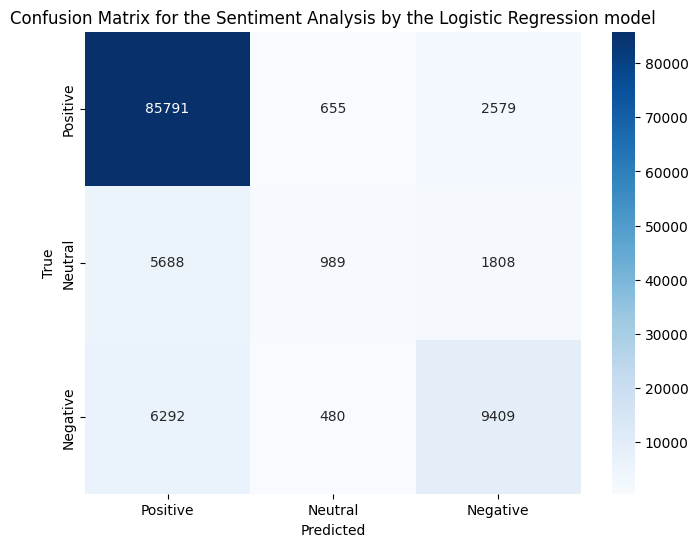

In [ ]:
#i. Confusion matrix

# Predict on test set
Y_pred = Lr_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, Y_pred, labels=['positive', 'neutral', 'negative'])

# Visualizing confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for the Sentiment Analysis by the Logistic Regression model')
plt.show()

Discussion

Strengths: The confusion matrix show that the model has 85791 true positive reviews as compared to the 9409 true negative reviews which provides a better view of the model performance on the data. The logistic model accuracy is 0.84 while the Bert embeddings model accuracy is 0.76 which indicates a strong model which is scalable for real-world deployment.

Limitations: The base model struggled with nuanced sentiment due to TF-IDF’s lack of contextual understanding. BERT was computationally expensive, limiting its use on large datasets without GPU resources.

Business Implications: This model will help the company to identify positive and negative sentiment trends, prioritize product improvements, and enhance customer service.

Recommendations:Conduct A/B testing in order to validate improvements driven by sentiment insights.

References

1. Amazon Customer Reviews Dataset. Available at: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews(Accessed: June 23, 2025).



